In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from config import *
from tqdm.auto import tqdm

import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, Input, Lambda,
    LeakyReLU, UpSampling2D, 
    MaxPool2D, 
    concatenate, Add, ZeroPadding2D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)

print(tf.__version__)

print(raw_train_dataset)

2.10.1
<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [3]:
for raw_train_data in raw_train_dataset.take(1):    
    example = tf.train.Example()
    example.ParseFromString(raw_train_data.numpy())  
    print(example)

features {
  feature {
    key: "classes_id"
    value {
      int64_list {
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
      }
    }
  }
  feature {
    key: "classes_name"
    value {
      bytes_list {
        value: "people"
        value: "people"
        value: "people"
        value: "people"
        value: "people"
        value: "people"
        value: "people"
        value: "people"
        value: "people"
        value: "people"
        value: "people"
        value: "people"
        value: "people"
        value: "people"
        value: "people"
      }
    }
  }
  feature {
    key: "filename"
    value {
      bytes_list {
        value: "uav0000013_00000_v_0000001.jpg"
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 7

In [2]:
for raw_train_data in raw_val_dataset.take(1):    
    example = tf.train.Example()
    example.ParseFromString(raw_train_data.numpy())  
    print(example)

features {
  feature {
    key: "classes_id"
    value {
      int64_list {
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
        value: 0
      }
    }
  }
  feature {
    key: "classes_name"
    value {
      bytes_list {
        value: "people"
        value: "people"
        value: "people"
        value: "people"
        value: "people"
        value: "people"
        value: "people"
        value: "people"
        value: "people"
        value: "people"
        value: "peopl

In [2]:
# Create a dictionary describing the features.
image_feature_description = {
    'filename': tf.io.FixedLenFeature([], tf.string),
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'classes_id': tf.io.VarLenFeature(tf.int64),
    'classes_name': tf.io.VarLenFeature(tf.string),
    'x_min': tf.io.VarLenFeature(tf.float32),
    'y_min': tf.io.VarLenFeature(tf.float32),
    'x_max': tf.io.VarLenFeature(tf.float32),
    'y_max': tf.io.VarLenFeature(tf.float32),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def parse_tf_example(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.io.parse_single_example(example_proto, image_feature_description)
    
    x_train = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)
    
    labels = tf.sparse.to_dense(parsed_example['classes_id'])
    labels = tf.cast(labels, tf.float32)
    
    xmin = tf.sparse.to_dense(parsed_example['x_min'])
    ymin = tf.sparse.to_dense(parsed_example['y_min'])
    xmax = tf.sparse.to_dense(parsed_example['x_max'])
    ymax = tf.sparse.to_dense(parsed_example['y_max'])
    
    y_train = tf.stack([xmin, ymin, xmax, ymax, labels], axis=1)
    
    return x_train, y_train

train_dataset = raw_train_dataset.map(parse_tf_example)
val_dataset = raw_val_dataset.map(parse_tf_example)
test_dataset = raw_test_dataset.map(parse_tf_example)
print(train_dataset)
print(val_dataset)
print(test_dataset)

<MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>


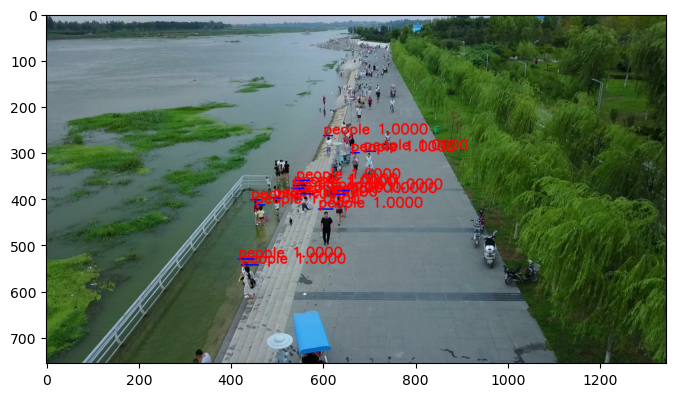

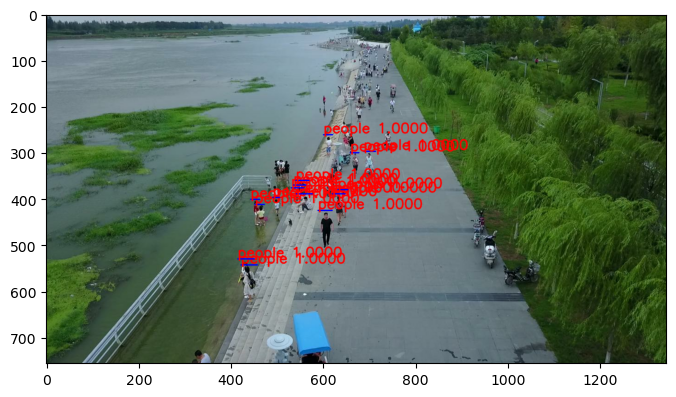

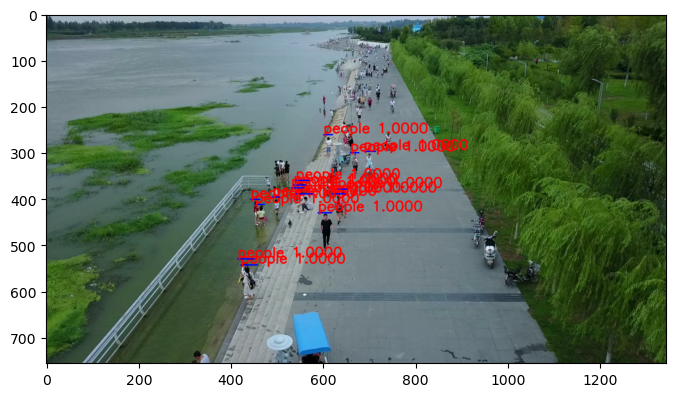

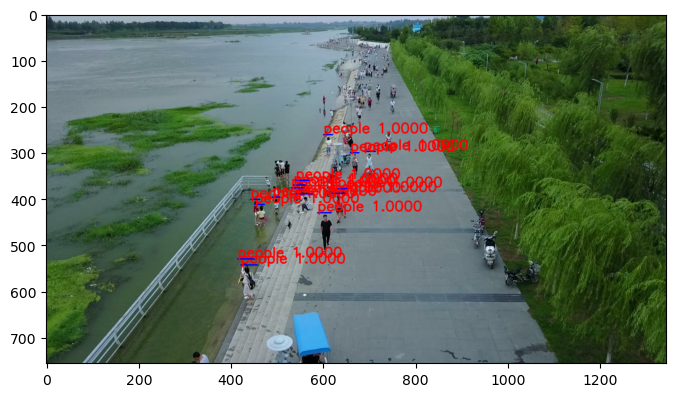

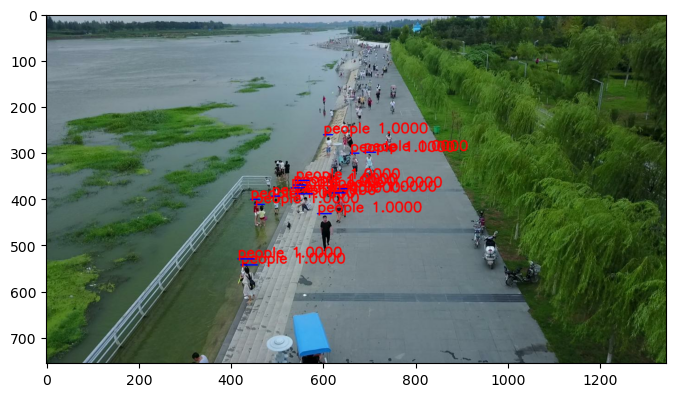

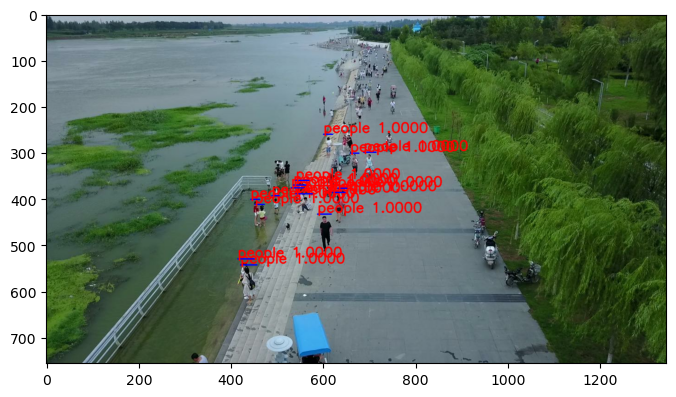

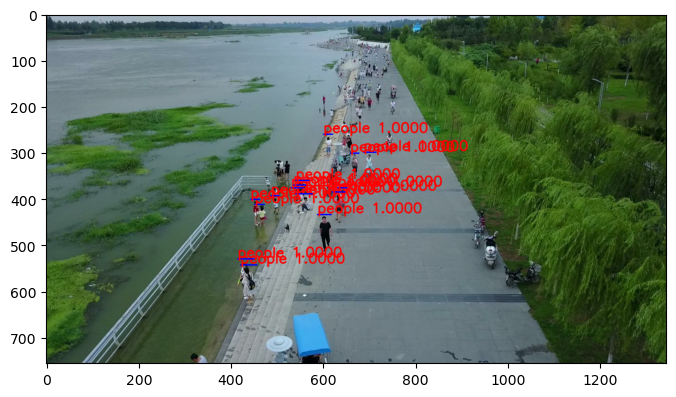

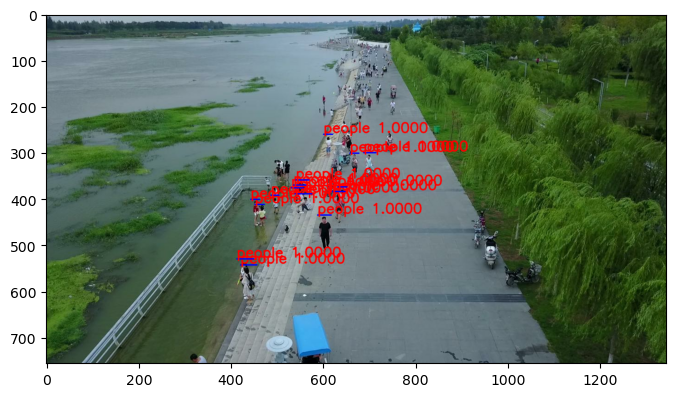

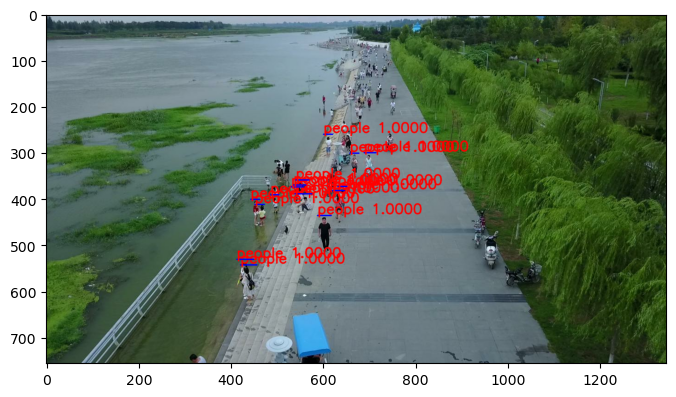

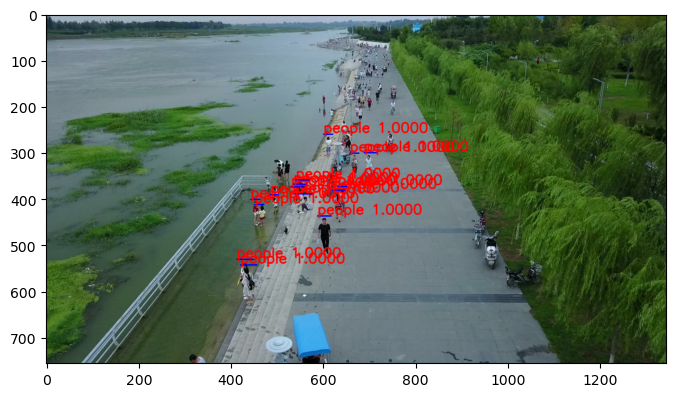

In [3]:
font_face = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_thickness = 2

for i, (x, y) in enumerate(train_dataset.take(10)):
    img = x.numpy()
    height, width = tf.shape(img)[0].numpy(), tf.shape(img)[1].numpy()
    
    for xmin, ymin, xmax, ymax, label in y.numpy():
        left = (xmin * width).astype('int32')
        top = (ymin * height).astype('int32')
        right = (xmax * width).astype('int32')
        bottom = (ymax * height).astype('int32')
        label = class_names[int(label)]
    
        # cv2.rectangle(image, (left, top), (right, bottom), color, thickness)
        cv2.rectangle(img, (left, top), (right, bottom), (0, 0, 255), 2)
        cv2.putText(img, '{} {:.4f}'.format(label, 1.0000), (left, int(top - 4)), 
                    font_face, font_scale, (255, 0, 0), font_thickness, cv2.LINE_AA)
    
    f, (ax1) = plt.subplots(1, 1, figsize=(8,8))
    f.subplots_adjust(hspace = .2, wspace = .05)
    
    # Save at data folder 10 samples
    cv2.imwrite("./data/output"+str(i+1)+".jpg", img)    
    
    ax1.imshow(img)

In [4]:
# anchor boxes
YOLO_ANCHORS = np.array(
    [(10, 13), (16, 30), (33, 23), 
     (30, 61), (62, 45), (59, 119),
     (116, 90), (156, 198), (373, 326)], np.float32) / 416

YOLO_ANCHORS_MASKS = np.array([[6, 7, 8],
                               [3, 4, 5],
                               [0, 1, 2]])

num_max_box = 100

@tf.function
def transform_bboxes_for_output(y_true, grid_size, anchor_idxs, best_anchor_idx):
    # y_true: (max_boxes, [x1, y1, x2, y2, classes])
    N = tf.shape(y_true)[0]
  
    # y_true_out: (grid, grid, anchors, [x, y, w, h, obj, class])
    y_true_out = tf.zeros(
        (grid_size, grid_size, tf.shape(anchor_idxs)[0], 6))
    
    anchor_idxs = tf.cast(anchor_idxs, tf.int32)
    
    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)
    
    # Find which grid includes the center of object
    #boxes_xy = y_true[..., 0:2]
    #grid_xy = tf.cast(boxes_xy // (1 / grid_size), tf.int32)

    for i in range(N):
        if tf.equal(y_true[i][0], 0):
            continue
        
        anchor_eq = tf.equal(
            anchor_idxs, best_anchor_idx[i][0])
        
        if tf.reduce_any(anchor_eq):
            # Find which grid includes the center of object
            boxes_xy = (y_true[i][0:2] + y_true[i][2:4]) / 2
            grid_xy = tf.cast(boxes_xy // (1 / grid_size), tf.int32)
            
            anchor_idx = tf.cast(tf.where(anchor_eq), tf.int32)

            indices = indices.write(i, [grid_xy[1], grid_xy[0], anchor_idx[0][0]])
            updates = updates.write(i, [y_true[i][0], y_true[i][1], y_true[i][2], y_true[i][3], 1, y_true[i][4]])
        
    #tf.print("indices: ", indices.stack())
    #tf.print("updates: ", updates.stack())
    
    return tf.tensor_scatter_nd_update(
        y_true_out, indices.stack(), updates.stack())

def transform_bboxes(y_train, anchors, anchor_masks, image_size=416):
    """Area of anchor."""
    # anchors shape: (9, 2)
    # Note: normalization anchors to 0~1 (anchors / 416)
    #       -> anchors and boxes_wh are moved to origin point
    #       -> we can conveniently find the minimum 
    #          between anchors and boxes_wh to find the intersection area.
    anchors = tf.cast(anchors, tf.float32)
    anchor_area = anchors[..., 0] * anchors[..., 1] # (9,)
    
    # y_train shape: (N, (x1, y1, x2, y2, classes))
    boxes_wh = y_train[..., 2:4] - y_train[..., 0:2] # (N, 2)
    
    # expand dimension for compare with anchor
    boxes_wh = tf.tile(tf.expand_dims(boxes_wh, -2),
                     (1, tf.shape(anchors)[0], 1)) # (N, 9, 2)
    boxes_area = boxes_wh[..., 0] * boxes_wh[..., 1] # (N, 9)
    
    """Find IOU between box shifted to origin and anchor box."""    
    intersection = tf.minimum(boxes_wh[..., 0], anchors[..., 0]) * \
        tf.minimum(boxes_wh[..., 1], anchors[..., 1]) # (N, 9)
    iou = intersection / (boxes_area + anchor_area - intersection) # (N, 9)
    
    """Find the best iou."""
    best_anchor_idx = tf.cast(tf.argmax(iou, axis=-1), tf.float32)
    best_anchor_idx = tf.expand_dims(best_anchor_idx, -1) # (N, 1)
    best_anchor_idx = tf.cast(best_anchor_idx, tf.int32)
    
    """Find which grid includes the center of object."""
    y_outs = []
    grid_size = image_size // 32

    for anchor_idxs in anchor_masks:
        y_outs.append(transform_bboxes_for_output(
            y_train, grid_size, anchor_idxs, best_anchor_idx))
        grid_size *=2

    return tuple(y_outs)

def preprocess_data(x_train, y_train, anchors, anchor_masks, size=416):
    """preprocess the data"""
    # Resize the image data.
    x_train = tf.image.resize(x_train, (size, size))
    x_train /= 255.
    
    # Origin boxes: (xmin, ymi, xmax, ymax, classes)
    """Add zero pad for training 
    
    paddings = [[row_top, row_bottom], [col_left, col_right]]
    """
    paddings = tf.clip_by_value([[0, num_max_box - tf.shape(y_train)[0]], [0, 0]],0,1)

    y_train = tf.pad(y_train, paddings)
    
    y_train = transform_bboxes(y_train, anchors, anchor_masks)
    
    return x_train, y_train

# Use deep copy()
anchors = YOLO_ANCHORS
anchor_masks = YOLO_ANCHORS_MASKS

train_dataset = train_dataset.map(lambda x, y: (
    preprocess_data(x, y, anchors, anchor_masks)))
val_dataset = val_dataset.map(lambda x, y: (
    preprocess_data(x, y, anchors, anchor_masks)))
test_dataset = test_dataset.map(lambda x, y: (
    preprocess_data(x, y, anchors, anchor_masks)))

print(train_dataset)
print(val_dataset)
print(test_dataset)

<MapDataset element_spec=(TensorSpec(shape=(416, 416, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(13, 13, 3, 6), dtype=tf.float32, name=None), TensorSpec(shape=(26, 26, 3, 6), dtype=tf.float32, name=None), TensorSpec(shape=(52, 52, 3, 6), dtype=tf.float32, name=None)))>
<MapDataset element_spec=(TensorSpec(shape=(416, 416, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(13, 13, 3, 6), dtype=tf.float32, name=None), TensorSpec(shape=(26, 26, 3, 6), dtype=tf.float32, name=None), TensorSpec(shape=(52, 52, 3, 6), dtype=tf.float32, name=None)))>
<MapDataset element_spec=(TensorSpec(shape=(416, 416, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(13, 13, 3, 6), dtype=tf.float32, name=None), TensorSpec(shape=(26, 26, 3, 6), dtype=tf.float32, name=None), TensorSpec(shape=(52, 52, 3, 6), dtype=tf.float32, name=None)))>


In [5]:
train_dataset = train_dataset.shuffle(buffer_size=512).batch(4)
train_dataset = train_dataset.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = val_dataset.batch(4)
test_dataset = test_dataset.batch(1)

print(test_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 416, 416, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 13, 13, 3, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 26, 26, 3, 6), dtype=tf.float32, name=None), TensorSpec(shape=(None, 52, 52, 3, 6), dtype=tf.float32, name=None)))>


In [6]:
class BatchNormalization(tf.keras.layers.BatchNormalization):
    """
    Make trainable=False freeze BN for real (the og version is sad)
    """
    
    def call(self, x, training=False):
        if training is None:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)
    
def DarknetConv2D(x, filters, size, stride=1, batch_norm=True):
    if stride == 1:
        padding = 'same'
    else:
        # downsample
        # padding=((top_pad, bottom_pad), (left_pad, right_pad))
        x = ZeroPadding2D(((1, 0), (1, 0)))(x) # top left half-padding
        padding = 'valid'
    
    x= Conv2D(filters=filters, kernel_size=size,
              strides=(stride, stride), padding=padding,
              use_bias=not batch_norm, 
              kernel_regularizer=tf.keras.regularizers.l2(0.0005))(x)
    
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    
    return x

def DarknetResidual(x, filters):
    prev = x
    x = DarknetConv2D(x, filters // 2, 1)
    x = DarknetConv2D(x, filters, 3)
    x = Add()([prev, x])
    return x

# ResidualBlock
def DarknetBlock(x, filters, num_blocks):
    x = DarknetConv2D(x, filters, 3, stride=2)
    for _ in range(num_blocks):
        x = DarknetResidual(x, filters)
    return x

def darknet_body(name=None):
    x = inputs = Input([None, None, 3])
    
    # Darknet53
    x = DarknetConv2D(x, 32, 3)
    x = DarknetBlock(x, 64, num_blocks=1)
    x = DarknetBlock(x, 128, num_blocks=2)
    x = x_36 = DarknetBlock(x, 256, num_blocks=8) # skip connection
    x = x_61 = DarknetBlock(x, 512, num_blocks=8) # conv + residual
    x = DarknetBlock(x, 1024, num_blocks=4) # x_74
    
    return Model(inputs, (x_36, x_61, x), name=name)

def yolo_body(filters, name=None):
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs
            
            # concat with skip connection
            x = DarknetConv2D(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = concatenate([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])
        
        x = DarknetConv2D(x, filters, 1)
        x = DarknetConv2D(x, filters * 2, 3)
        x = DarknetConv2D(x, filters, 1)
        x = DarknetConv2D(x, filters * 2, 3)
        x = DarknetConv2D(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
    return yolo_conv

def yolo_output(filters, num_anchors, classes, name=None):
    def yolo_output_conv(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv2D(x, filters * 2, 3)
        x = DarknetConv2D(x, (num_anchors * (classes + 5)), 1, batch_norm=False)
        # output
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2], 
                                            num_anchors, classes + 5)))(x)
        return Model(inputs, x, name=name)(x_in)
    return yolo_output_conv

def Yolov3(size=None, channels=3, 
           anchors=YOLO_ANCHORS, masks=YOLO_ANCHORS_MASKS,
           classes=80):    
    x = inputs = Input([size, size, channels], name='input')
    
    # Darknet53
    '''
    x = DarknetConv2D(x, 32, 3)
    x = DarknetBlock(x, 64, num_blocks=1)
    x = DarknetBlock(x, 128, num_blocks=2)
    x = x_36 = DarknetBlock(x, 256, num_blocks=8) # skip connection
    x = x_61 = DarknetBlock(x, 512, num_blocks=8) # conv + residual
    x = DarknetBlock(x, 1024, num_blocks=4) # x_74
    '''
    x_36, x_61, x = darknet_body(name='yolo_darknet')(x)
    
    ##############################################################################
    # Yolo Body
    '''
    x = DarknetConv2D(x, 512, 1)
    x = DarknetConv2D(x, 1024, 3)
    x = DarknetConv2D(x, 512, 1)
    x = DarknetConv2D(x, 1024, 3)
    x = x_79 = DarknetConv2D(x, 512, 1)
    
    # Yolo Output 1. 13x13x(anchor*(classes+5)
    x = DarknetConv2D(x, 1024, 3)
    x = DarknetConv2D(x, (num_anchors * (classes + 5)), 1, batch_norm=False)
    output_0 = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2], 
                                               num_anchors, classes + 5)))(x)
    '''
    x = yolo_body(512, name='yolo_conv_0')(x)
    output_0 = yolo_output(512, len(masks[0]), classes, name='yolo_output_0')(x)
                           
    ############################################################################## 
    '''
    # 82, output_0
    # 83, route -4 -> x_79
    # x_79 upsample + x_61
    x = DarknetConv2D(x_79, 256, 1) # x_84
    x = UpSampling2D(2)(x)
    x = concatenate([x, x_61]) 
    
    # Yolo Body
    x = DarknetConv2D(x, 256, 1)
    x = DarknetConv2D(x, 512, 3)
    x = DarknetConv2D(x, 256, 1)
    x = DarknetConv2D(x, 512, 3)
    x = x_91 = DarknetConv2D(x, 256, 1) 
    
    # Yolo Output 2. 26x26x(anchor*(classes+5)
    x = DarknetConv2D(x, 512, 3)
    x = DarknetConv2D(x, (num_anchors * (classes + 5)), 1, batch_norm=False)             
    output_1 = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2], 
                                               num_anchors, classes + 5)))(x)
    '''
    x = yolo_body(256, name='yolo_conv_1')((x, x_61))
    output_1 = yolo_output(256, len(masks[1]), classes, name='yolo_output_1')(x)
    
    ##############################################################################  
    '''
    # 94, output_1
    # 95. route -4 -> x_91
    # x_91 upsample + x_36
    x = DarknetConv2D(x_91, 128, 1) # x_92
    x = UpSampling2D(2)(x)
    x = concatenate([x, x_36])
    
    # Yolo Body
    x = DarknetConv2D(x, 128, 1)
    x = DarknetConv2D(x, 256, 3)
    x = DarknetConv2D(x, 128, 1)
    x = DarknetConv2D(x, 256, 3)
    x = x_91 = DarknetConv2D(x, 128, 1)
    
    # Yolo Output 3. 52x52x(anchor*(classes+5)
    x = DarknetConv2D(x, 256, 3)
    x = DarknetConv2D(x, (num_anchors * (classes + 5)), 1, batch_norm=False)
    output_2 = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2], 
                                               num_anchors, classes + 5)))(x)
    '''
    x = yolo_body(128, name='yolo_conv_2')((x, x_36)) # x_103
    # Yolo Output 3. 52x52x(anchor*(classes+5)
    output_2 = yolo_output(128, len(masks[2]), classes, name='yolo_output_2')(x) # x_106

    return Model(inputs, (output_0, output_1, output_2), name='yolov3')

model = Yolov3(416, classes = n_classes)
model.summary()

Model: "yolov3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 yolo_darknet (Functional)      ((None, None, None,  40620640    ['input[0][0]']                  
                                 256),                                                            
                                 (None, None, None,                                               
                                 512),                                                            
                                 (None, None, None,                                          

In [7]:
def yolo_bboxes(pred, anchors, classes):
    """YOLO bounding box formula

    bx = sigmoid(tx) + cx
    by = sigmoid(ty) + cy
    bw = pw * exp^(tw)
    bh = ph * exp^(th)
    Pr(obj) * IOU(b, object) = sigmoid(to) # confidence

    (tx, ty, tw, th, to) are the output of the model.
    """
    # pred: (batch_size, grid, grid, anchors, (tx, ty, tw, th, conf, ...classes))
    grid_size = tf.shape(pred)[1]

    box_xy = tf.sigmoid(pred[..., 0:2])
    box_wh = pred[..., 2:4]
    box_confidence = tf.sigmoid(pred[..., 4:5])
    box_class_probs = tf.sigmoid(pred[..., 5:])
    # Darknet raw box
    pred_raw_box = tf.concat((box_xy, box_wh), axis=-1)

    # box_xy: (grid_size, grid_size, num_anchors, 2)
    # grid: (grdid_siez, grid_size, 1, 2)
    #       -> [0,0],[0,1],...,[0,12],[1,0],[1,1],...,[12,12]
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors
    pred_box = tf.concat((box_xy, box_wh), axis=-1)

    return pred_box, box_confidence, box_class_probs, pred_raw_box

In [8]:
def freeze_all(model, frozen=True):
    model.trainable = not frozen
    if isinstance(model, tf.keras.Model):
        for l in model.layers:
            freeze_all(l, frozen)

In [9]:
# YOLOv3 LOSS
def YoloLoss(anchors, classes=80, ignore_thresh=0.5):
    def yolo_loss(y_true, y_pred):
        """"1. transform all pred outputs."""
        # y_pred: (batch_size, grid, grid, anchors, (tx, ty, tw, th, conf, ...cls))
        pred_box, pred_confidence, pred_class_probs, pred_raw_box = yolo_bboxes(
            y_pred, anchors, classes)
        pred_raw_xy = pred_raw_box[..., 0:2]
        pred_raw_wh = pred_raw_box[..., 2:4]

        """2. transform all true outputs."""
        # y_true: (batch_size, grid, grid, anchors, (x1, y1, x2, y2, conf, cls))
        true_box, true_confidence, true_class = tf.split(
            y_true, (4, 1, 1), axis=-1)
        true_xy = (true_box[..., 0:2] + true_box[..., 2:4]) / 2
        true_wh = true_box[..., 2:4] - true_box[..., 0:2]
        true_boxes = tf.concat([true_xy, true_wh], axis=-1)

        # give higher weights to small boxes
        box_loss_scale = 2 - true_wh[..., 0] * true_wh[..., 1]

        """3. Invert ture_boxes to darknet style box to calculate loss."""
        grid_size = tf.shape(y_true)[1]
        grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
        grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)
        true_raw_xy = true_xy * tf.cast(grid_size, tf.float32) - \
            tf.cast(grid, tf.float32)
        true_raw_wh = tf.math.log(true_wh / anchors)
        true_raw_wh = tf.where(tf.math.is_inf(true_wh),
                           tf.zeros_like(true_wh), true_wh)  # avoid log(0)=-inf

        """4. calculate all masks."""
        """4-1. object mask: remove noobject cell."""
        # true_confidence: cell has object or not
        #                 0/1 mask for detectors in [conv_height, conv_width, num_anchors, 1]
        # true_confidence_mask: [conv_height, conv_width, num_anchors]
        true_conf_mask = tf.squeeze(true_confidence, -1)

        """4-2. ignore mask.

        1. Find the IOU score of each predicted box
           with each ground truth box.
        2. Find the Best IOU scores.
        3. A confidence detector that this cell has object
           if IOU > threshold otherwise no object.
        """
        # Reshape true_box: (N, grid, grid, num_anchors, 4) to (N, num_true_boxes, 4)
        true_boxes_flat = tf.boolean_mask(true_boxes, tf.cast(true_conf_mask, tf.bool))

        # broadcast shape: (N, grid, grid, num_anchors, num_true_boxes, (x, y, w, h))
        true_boxes = tf.expand_dims(true_boxes, -2) # (N, 13, 13, 3, 1, 4)
        true_boxes_flat = tf.expand_dims(true_boxes_flat, 0) # (1, num_true_boxes, 4)
        new_shape = tf.broadcast_dynamic_shape(tf.shape(true_boxes), tf.shape(true_boxes_flat)) # (N, 13, 13, 3, num_true_boxes, 4)

        # reshape: (batch, conv_height, conv_width, num_anchors, num_true_boxes, box_params)
        true_boxes = tf.broadcast_to(true_boxes, new_shape)
        true_xy = true_boxes[..., 0:2]
        true_wh = true_boxes[..., 2:4] # (N, 13, 13, 5, num_true_boxes, 2)

        true_wh_half = true_wh / 2.
        true_mins = true_xy - true_wh_half
        true_maxes = true_xy + true_wh_half

        # Expand pred (x,y,w,h) to allow comparison with ground truth.
        # (batch, conv_height, conv_width, num_anchors, 1, box_params)
        pred_xy = pred_box[..., 0:2]
        pred_wh = pred_box[..., 2:4]
        pred_xy = tf.expand_dims(pred_xy, 4)
        pred_wh = tf.expand_dims(pred_wh, 4)

        pred_wh_half = pred_wh / 2.
        pred_mins = pred_xy - pred_wh_half
        pred_maxes = pred_xy + pred_wh_half

        intersection_mins = tf.maximum(pred_mins, true_mins)
        intersection_maxes = tf.minimum(pred_maxes, true_maxes)
        intersection_wh = tf.maximum(intersection_maxes - intersection_mins, 0.)
        intersection_areas = intersection_wh[..., 0] * intersection_wh[..., 1] # (-1, 13, 13, 3, num_true_boxes)

        pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
        true_areas = true_wh[..., 0] * true_wh[..., 1]

        """4-2-1. Calculate IOU scores for each location."""
        union_areas = pred_areas + true_areas - intersection_areas
        iou_scores = intersection_areas / union_areas # (-1, 13, 13, 3, num_true_boxes)

        """4-2-2. Best IOU scores."""
        best_ious = tf.reduce_max(iou_scores, axis=4)

        """4-2-3. Ignore mask."""
        # ignore false positive when iou is over threshold
        ignore_mask = tf.cast(best_ious < ignore_thresh, tf.float32) # (-1, 13, 13, 3, 1)

        """5. calculate all losses."""
        # Calculate `coordinate loss`."""
        xy_loss = box_loss_scale * true_conf_mask * \
                  tf.reduce_sum(tf.square(true_raw_xy - pred_raw_xy), axis=-1)
        wh_loss = box_loss_scale * true_conf_mask * \
                  tf.reduce_sum(tf.square(true_raw_wh - pred_raw_wh), axis=-1)

        # Calculate `classification loss`."""
        # square(one_hot(true_class) - pred_class_probs)
        # TODO: use binary_crossentropy instead
        #   - true_class:       13x13x3x1
        #   - pred_class_probs: 13x13x3x20
        classification_loss = true_conf_mask * sparse_categorical_crossentropy(
                true_class, pred_class_probs)

        # Calculate Confidence loss."""
        objects_loss = binary_crossentropy(true_confidence, pred_confidence)
        confidence_loss = true_conf_mask * objects_loss + \
                          (1 - true_conf_mask) * ignore_mask * objects_loss

        """6. sum over (batch, gridx, gridy, anchors) => (batch, 1)."""
        xy_loss_sum = tf.reduce_sum(xy_loss, axis=(1, 2, 3))
        wh_loss_sum = tf.reduce_sum(wh_loss, axis=(1, 2, 3))
        confidence_loss_sum = tf.reduce_sum(confidence_loss, axis=(1, 2, 3))
        classification_loss_sum = tf.reduce_sum(classification_loss, axis=(1, 2, 3))
        
        '''
        tf.print(xy_loss_sum)
        tf.print(wh_loss_sum)
        tf.print(confidence_loss_sum)
        tf.print(classification_loss_sum)
        '''
        
        return (xy_loss_sum + wh_loss_sum + confidence_loss_sum + classification_loss_sum)
    return yolo_loss


In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
yolo_loss = [YoloLoss(anchors[mask], classes = n_classes)
             for mask in anchor_masks]

model.compile(optimizer=optimizer,loss=yolo_loss, run_eagerly=False)

if not os.path.exists(model_ckpt_dir):
    os.makedirs(model_ckpt_dir)

callbacks = [ReduceLROnPlateau(verbose=1),EarlyStopping(patience=10, verbose=1),
             ModelCheckpoint(model_ckpt, verbose=1, save_weights_only=True),  (log_dir='logs/try_0')]

In [11]:
history = model.fit(train_dataset, epochs = 10,callbacks=callbacks, validation_data=val_dataset)
# Save and Load model
model_path = "checkpoints/basemodel_try_01/"
tf.saved_model.save(model_path)

if not os.path.exists(model_path):
    os.makedirs(model_path)
model.save(os.path.join(model_path,"yolov3_train.h5"))

Epoch 1/10
   6025/Unknown - 1597s 262ms/step - loss: 78.7479 - yolo_output_0_loss: 0.7314 - yolo_output_1_loss: 2.1471 - yolo_output_2_loss: 65.9689
Epoch 1: saving model to ./checkpoints/basemodel_try_01\yolov3.tf
6025/6025 [==============================] - 1656s 272ms/step - loss: 78.7479 - yolo_output_0_loss: 0.7314 - yolo_output_1_loss: 2.1471 - yolo_output_2_loss: 65.9689 - val_loss: nan - val_yolo_output_0_loss: nan - val_yolo_output_1_loss: nan - val_yolo_output_2_loss: nan - lr: 0.0010
Epoch 2/10
6025/6025 [==============================] - ETA: 0s - loss: 51.8529 - yolo_output_0_loss: 0.0181 - yolo_output_1_loss: 0.0263 - yolo_output_2_loss: 42.9219
Epoch 2: saving model to ./checkpoints/basemodel_try_01\yolov3.tf
6025/6025 [==============================] - 1556s 258ms/step - loss: 51.8529 - yolo_output_0_loss: 0.0181 - yolo_output_1_loss: 0.0263 - yolo_output_2_loss: 42.9219 - val_loss: nan - val_yolo_output_0_loss: nan - val_yolo_output_1_loss: nan - val_yolo_output_2_los

NameError: name 'path' is not defined

In [23]:
import pickle
with open('./logs/try_0/histroy.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# load
with open('./logs/try_0/histroy.pickle', 'rb') as f:
    data = pickle.load(f)

C:\Users\rh987\AppData\Local\Temp\ipykernel_5616\1473357387.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


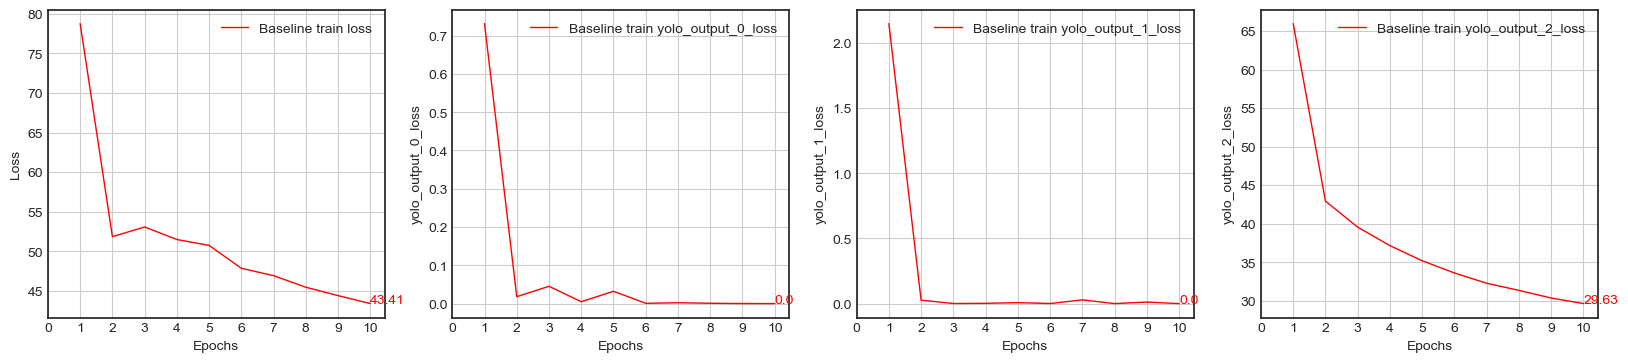

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def show_lcurve(hists, titles, colors=["r","g","b","k"], size=(20,4), x_itv=1, lw=1):
    plt.figure(figsize=size)
    plt.style.use("seaborn-white")
    # loss 
    plt.subplot(141)
    for i, hist in enumerate(hists):
        loss = hist.history['loss']
        epochs = range(1, 1+len(loss))
        xbins = range(0, len(loss)+1, x_itv)
        plt.plot(epochs, loss, lw=lw,linestyle='-', label=f'{titles[i]} train loss', c=colors[i])
        plt.legend();plt.grid(True);plt.xticks(xbins)
        plt.xlabel('Epochs');plt.ylabel('Loss')
        x, y = epochs[-1], hist.history['loss'][-1]
        plt.text(x, y, np.round(y,2), c=colors[i])
    
    # acc
    plt.subplot(142)
    for i, hist in enumerate(hists):
        loss = hist.history['yolo_output_0_loss']
        epochs = range(1, 1+len(loss))
        xbins = range(0, len(loss)+1, x_itv)
        plt.plot(epochs, loss, lw=lw,linestyle='-', label=f'{titles[i]} train yolo_output_0_loss', c=colors[i])
        plt.legend();plt.grid(True);plt.xticks(xbins)
        plt.xlabel('Epochs');plt.ylabel('yolo_output_0_loss')
        x, y = epochs[-1], hist.history['yolo_output_0_loss'][-1]
        plt.text(x, y, np.round(y,2), c=colors[i])
        
    plt.subplot(143)
    for i, hist in enumerate(hists):
        loss = hist.history['yolo_output_1_loss']
        epochs = range(1, 1+len(loss))
        xbins = range(0, len(loss)+1, x_itv)
        plt.plot(epochs, loss, lw=lw,linestyle='-', label=f'{titles[i]} train yolo_output_1_loss', c=colors[i])
        plt.legend();plt.grid(True);plt.xticks(xbins)
        plt.xlabel('Epochs');plt.ylabel('yolo_output_1_loss')
        x, y = epochs[-1], hist.history['yolo_output_1_loss'][-1]
        plt.text(x, y, np.round(y,2), c=colors[i])
        
    plt.subplot(144)
    for i, hist in enumerate(hists):
        loss = hist.history['yolo_output_2_loss']
        epochs = range(1, 1+len(loss))
        xbins = range(0, len(loss)+1, x_itv)
        plt.plot(epochs, loss, lw=lw,linestyle='-', label=f'{titles[i]} train yolo_output_2_loss', c=colors[i])
        plt.legend();plt.grid(True);plt.xticks(xbins)
        plt.xlabel('Epochs');plt.ylabel('yolo_output_2_loss')
        x, y = epochs[-1], hist.history['yolo_output_2_loss'][-1]
        plt.text(x, y, np.round(y,2), c=colors[i])
    plt.show()
    
show_lcurve([history], ["Baseline"])

# test

In [24]:
yolo = Yolov3(classes=n_classes)
model_ckpt = "./checkpoints/basemodel_try_01/yolov3.tf"
yolo.load_weights(model_ckpt)

In [25]:
def yolo_boxes_and_scores(yolo_output, anchors, classes=n_classes):
    # yolo_boxes: pred_box, box_confidence, box_class_probs, pred_raw_box
    pred_box, box_confidence, box_class_probs, pred_raw_box = yolo_bboxes(yolo_output, anchors, classes)

    # Convert boxes to be ready for filtering functions.
    # Convert YOLO box predicitions to bounding box corners.
    # (x, y, w, h) -> (x1, y1, x2, y2)
    box_xy = pred_box[..., 0:2]
    box_wh = pred_box[..., 2:4]
    box_x1y1 = box_xy - (box_wh / 2.)
    box_x2y2 = box_xy + (box_wh / 2.)
    boxes = tf.concat([box_x1y1, box_x2y2], axis=-1)
    boxes = tf.reshape(boxes, [-1, 4])

    # Compute box scores
    box_scores = box_confidence * box_class_probs
    box_scores = tf.reshape(box_scores, [-1, classes])
    return boxes, box_scores

def yolo_non_max_suppression(boxes, box_scores, 
                             classes=n_classes, 
                             max_boxes=100,
                             score_threshold=0.5,
                             iou_threshold=0.5):
    """Perform Score-filtering and Non-max suppression

    boxes: (10647, 4)
    box_scores: (10647, 80)
    # 10647 = (13*13 + 26*26 + 52*52) * 3(anchor)
    """

    # Create a mask, same dimension as box_scores.
    mask = box_scores >= score_threshold # (10647, 80)

    output_boxes = []
    output_scores = []
    output_classes = []

    # Perform NMS for all classes
    for c in range(classes):
        class_boxes = tf.boolean_mask(boxes, mask[:, c])
        class_box_scores = tf.boolean_mask(box_scores[:, c], mask[:, c])

        selected_indices = tf.image.non_max_suppression(
            class_boxes, class_box_scores, max_boxes, iou_threshold)

        class_boxes = tf.gather(class_boxes, selected_indices)
        class_box_scores = tf.gather(class_box_scores, selected_indices)

        classes = tf.ones_like(class_box_scores, 'int32') * c

        output_boxes.append(class_boxes)
        output_scores.append(class_box_scores)
        output_classes.append(classes)

    output_boxes = tf.concat(output_boxes, axis=0)
    output_scores = tf.concat(output_scores, axis=0)
    output_classes = tf.concat(output_classes, axis=0)

    return output_scores, output_boxes, output_classes

def yolo_eval(yolo_outputs, 
              image_shape=(416, 416), 
              classes=n_classes, 
              max_boxes=100, 
              score_threshold=0.5, 
              iou_threshold=0.5):
    # Retrieve outputs of the YOLO model.
    for i in range(0,3):
        _boxes, _box_scores = yolo_boxes_and_scores(yolo_outputs[i], anchors[6-3*i:9-3*i], classes)
        if i == 0:
            boxes, box_scores = _boxes, _box_scores
        else:
            boxes = tf.concat([boxes, _boxes], axis=0)
            box_scores = tf.concat([box_scores, _box_scores], axis=0)

    # Perform Score-filtering and Non-max suppression
    scores, boxes, classes = yolo_non_max_suppression(boxes, box_scores,
                                                      classes,
                                                      max_boxes,
                                                      score_threshold,
                                                      iou_threshold)

    return scores, boxes, classes

def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    height, width = image_shape
    image_dims = tf.stack([width, height, width, height])
    image_dims = tf.cast(tf.reshape(image_dims, [1, 4]), tf.float32)
    boxes = boxes * image_dims
    return boxes

import colorsys
import random

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

def draw_outputs(image, outputs, class_names, colors):
    h, w, _ = image.shape
    scores, boxes, classes = outputs
    boxes = scale_boxes(boxes, (h, w))

    for i in range(scores.shape[0]):
        left, top, right, bottom = boxes[i]
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(h, np.floor(bottom + 0.5).astype('int32'))
        right = min(w, np.floor(right + 0.5).astype('int32'))
        class_id = int(classes[i])
        predicted_class = class_names[class_id]
        score = scores[i].numpy()

        label = '{} {:.2f}'.format(predicted_class, score)

        # colors: RGB
        cv2.rectangle(image, (left, top), (right, bottom), tuple(colors[class_id]), 6)

        font_face = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_thickness = 2

        label_size = cv2.getTextSize(label, font_face, font_scale, font_thickness)[0]
        label_rect_left, label_rect_top = int(left - 3), int(top - 3)
        label_rect_right, label_rect_bottom = int(left + 3 + label_size[0]), int(top - 5 - label_size[1])
        cv2.rectangle(image, (label_rect_left, label_rect_top), (label_rect_right, label_rect_bottom),
                      tuple(colors[class_id]), -1)

        cv2.putText(image, label, (left, int(top - 4)),
                    font_face, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)
        
    return image

1/1 [==============================] - 0s 27ms/step
detections:


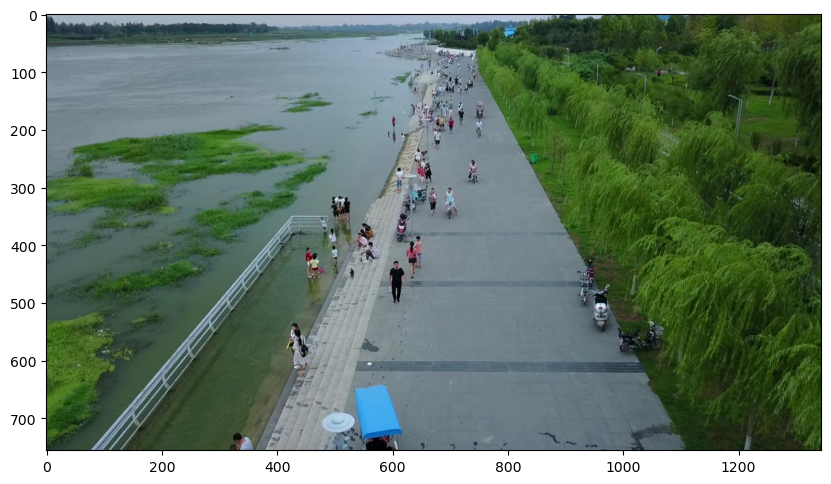

In [32]:
# Pick an image
img_filepath = "./data/uav0000013_00000_v_0000001.jpg"

# Use OpenCV to read in images
images = cv2.imread(img_filepath)             # Load image
images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)

# Pre-processing of image input
input_image = cv2.resize(images, (416, 416))   # Modify the input image size to meet the requirements of the model
input_image = input_image / 255.               # Perform image normalization
input_image = np.expand_dims(input_image, 0)   # increase batch dimension

# Perform image detection
yolo_outputs = yolo.predict(input_image)
scores, boxes, classes = yolo_eval( yolo_outputs, score_threshold=0.01, iou_threshold=0.01)

# Generate colors for drawing bounding boxes.
colors = generate_colors(class_names)

print("detections:")
for i in range(scores.shape[0]):
    print("\t{}, {}, {}".format(
        class_names[int(classes[i])], scores[i], boxes[i]
    ))

# Draw bounding boxes on the image file
image = draw_outputs(images, (scores, boxes, classes), class_names, colors)

# Save
cv2.imwrite("./data/output.jpg", image)

plt.figure(figsize=(10, 10))
plt.imshow(image)